The aim of this notebook is to improve on notebook 7.
This notebook contains:
- Loading Sentinel-2 data and WorldCover data, and saving to a Zarr file using Dask
- Model and dataset definitions for an 11-class Prithvi based classification model based on the WorldCover dataset
- A training function using DDP and `dask_pytorch_ddp` to finetune Prithvi
- Various tests for each component

**Note**: This notebook takes advantage of GPU enabled clusters so uase an appropriate image and set `options.cuda_worker = True` when calling dask workers.

Things I have done in order:
1. Ice Chunk + DDP + Batch Iterator - Compute Weights
  - This mainly helps with read and write speed of the zarr storage
2. Ice Chunk + DDP + cupy + dlpack + Batch Iterator
  - Interestingly this doesn't "show up" as Tasks on the Dask dashboard. Having a direct pipe to GPU memory seems to bypass Dask's task tracking
  - Zarr does not support cupy reads if in the cloud, will always be numpy
3. Dali + Ice Chunk + DDP  + Batch Iterator


In [2]:
# Common imports and settings
import os, sys, re, io
from pathlib import Path
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr
import dask
from dask.distributed import Client
from dask_gateway import Gateway
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import numpy as np
# Datacube
import datacube
from datacube.utils.aws import configure_s3_access
import odc.geo.xr                                  # https://github.com/opendatacube/odc-geo
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool                  # https://github.com/opendatacube/odc-tools/blob/develop/libs/algo/odc/algo/_masking.py
from dea_tools.plotting import display_map, rgb    # https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools

import boto3
import time

# Basic plots
%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Holoviews
# https://holoviz.org/tutorial/Composing_Plots.html
# https://holoviews.org/user_guide/Composing_Elements.html
import hvplot.pandas
import hvplot.xarray
import panel as pn
import colorcet as cc
import cartopy.crs as ccrs
from datashader import reductions
from holoviews import opts
# hv.extension('bokeh', logo=False)
print("Libraries loaded successfully.")

Libraries loaded successfully.


In [3]:
# EASI defaults
# These are convenience functions so that the notebooks in this repository work in all EASI deployments

# The `git.Repo()` part returns the local directory that easi-notebooks has been cloned into
# If using the `easi-tools` functions from another path, replace `repo` with your local path to `easi-notebooks` directory
try:
    import git
    repo = git.Repo('.', search_parent_directories=True).working_tree_dir    # Path to this cloned local directory
except (ImportError, git.InvalidGitRepositoryError):
    repo = Path.home() / 'easi-notebooks'    # Reasonable default
    if not repo.is_dir():
        raise RuntimeError('To use `easi-tools` please provide the local path to `https://github.com/csiro-easi/easi-notebooks`')
if repo not in sys.path:
    sys.path.append(str(repo))    # Add the local path to `easi-notebooks` to python

from easi_tools import EasiDefaults
from easi_tools import initialize_dask, xarray_object_size, mostcommon_crs, heading, setup_cluster
#from easi_tools.load_s2l2a import load_s2l2a_with_offset
print("EASI librariies loaded successfully.")

EASI librariies loaded successfully.


In [4]:
from easi_tools.dask_training import (
    GeoBatchSpec,
    BatchAdapter,
    get_num_samples,
    make_dali_iterator,
    train_one_epoch,
    evaluate,
    SegmentationTask,
    wrap_model_with_fsdp,
    train_one_epoch_log,
    WorldCoverLabelMapper,
    load_latest_training_log,
    test_model,
    inspect_timing,
    wrap_model_with_ddp
)

print("EASI tools loaded successfully")

ImportError: cannot import name 'wrap_model_with_ddp' from 'easi_tools.dask_training' (/home/jovyan/easi-notebooks/easi_tools/dask_training/__init__.py)

In [ ]:
import torch
from terratorch.registry import BACKBONE_REGISTRY

from dask_pytorch_ddp import dispatch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from torch import nn
from torch.utils.data import Dataset
import torch.multiprocessing as mp

from datetime import datetime#, timedelta
import json
import torch.distributed as dist
import terratorch


from s3torchconnector import S3Checkpoint

from torch.optim.lr_scheduler import StepLR


from sklearn.model_selection import train_test_split



from torch.distributed.fsdp import (
    FullyShardedDataParallel as FSDP,
    StateDictType,
    FullStateDictConfig,
    FullOptimStateDictConfig,
)


#from torch.utils import dlpack

print("DL libraries imported successfully")

# Dask Setup

In [ ]:
gateway = Gateway()
options = gateway.cluster_options()
# To get GPUs you must specify
options.cuda_worker = True
clusters = gateway.list_clusters()
if not clusters:
    print('Creating new cluster...')
    cluster = gateway.new_cluster(cluster_options=options)
else:
    print(f'Connecting to existing cluster: {clusters[0].name}')
    cluster = gateway.connect(clusters[0].name)

NUM_WORKERS = 2
cluster.scale(NUM_WORKERS)
client = cluster.get_client()

print("Cluster Dashboard:", client.dashboard_link)

In [27]:
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client);

# Data Prep
We will use the s3 bucket spcified linked to my EASI acount for storing the data.

In [7]:
# === S3 SETUP ===
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
base_prefix = f"{userid}/{project_name}"
s3_base = f"{bucket}/{base_prefix}"

print(bucket)
repo_prefix = f"{userid}/{project_name}/training_dataset_v4-icechunk"

log_dir = f"{userid}/{project_name}/logs/"
output_dir = f"{userid}/{project_name}/models/"

Successfully found configuration for deployment "csiro"
easihub-csiro-user-scratch


This implimentation uses `Dask-Pytorch-DDP`, `Ice Chunk` and `NVIDIA Dali`, if they don't come on the workers by default we need to install them. We will also give the cluster to some of the easi-tools helper libraries:

In [19]:
setup_cluster(client);

Setting up cluster (workers + scheduler)...
Cluster setup complete!


True

# Fine Tuning Setup
We want to define:
- The model we will be fine tuning
- The dataset that will read from the S3 Bucket and feed data to the model during training

Both the model and dataset will usually depend on your specific use case but some general things for fine tunning:
- Make sure to freeze tha backbone of the model
- Make sure the forward pass fits you dataset dims or vice versa
- Do any transformations you need within the dataset

For this Prithvi Model we:
- Loaded in the backbone
- Froze the weights
- Added a decoader head
- Added a robust forward pass that goes through the backbone and to the new head

In [8]:
class PrithviBackbone(nn.Module):
    def __init__(self, embed_dim=1024, freeze=True, num_frames=3):
        super().__init__()
        self.encoder = BACKBONE_REGISTRY.build(
            "prithvi_eo_v2_300",
            pretrained=True,
            num_frames=num_frames,
        )
        if freeze:
            for p in self.encoder.parameters():
                p.requires_grad = False
        self.embed_dim = embed_dim

    def forward(self, x):
        # x: (B, C, T, H, W)
        assert x.dim() == 5
        B, C, T, H, W = x.shape

        features = self.encoder(x)
        if isinstance(features, (list, tuple)):
            features = features[-1]  # (B, L, C2)

        if features.dim() == 3:
            if features.shape[1] % (T * (H // 16) * (W // 16)) == 1:
                features = features[:, 1:, :]

            B2, L, C2 = features.shape
            t_patches = T
            h_patches = H // 16
            w_patches = W // 16
            assert L == t_patches * h_patches * w_patches

            features = features.view(B2, t_patches, h_patches, w_patches, C2)
            features = features.mean(dim=1)            # (B, H_p, W_p, C2)
            features = features.permute(0, 3, 1, 2)    # (B, C2, H_p, W_p)

        return features, (H, W)  # 2D feature map + original spatial size



class SegmentationHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False),
            nn.Conv2d(128, num_classes, kernel_size=1),
        )

    def forward(self, features, orig_hw):
        H, W = orig_hw
        logits = self.decode(features)
        logits = nn.functional.interpolate(
            logits, size=(H, W), mode="bilinear", align_corners=False
        )
        return logits



class PrithviSegmentation(nn.Module):
    def __init__(self, num_classes=11, freeze_backbone=True):
        super().__init__()
        self.backbone = PrithviBackbone(embed_dim=1024, freeze=freeze_backbone)
        self.head = SegmentationHead(in_channels=1024, num_classes=num_classes)

    def forward(self, x):
        features, orig_hw = self.backbone(x)
        logits = self.head(features, orig_hw)
        return logits

To make sure your dataset and model definition are correct you can run simple checks to determine input and output shape. Then you can build you decoder and dataset around that.

For this dataset we:
- Map the world Cover outputs to nicer class values
- Filter out any invalid values
- Convert to tensors


To help generalise the dataset, all datasets should return in the form of a dict, see `accelerated_io.py` for implimentation.

Zarr currently cannot reliably stream chunks from S3 directly into `cup.array`, so reads usually (always in my tests) go through CPU memory making it `numpy.array`.

Need to make the iterator inside the dali pipeline or it breaks

# Fine Tuning
In order to make this interchangeable with other problems, we will use a "Task" template and then fill it out with our specific needs.

Training has been broken up into steps so it is easy to replace with differnt model, tasks, etc...
We have:
- `to_device` and `wrap_model_with_fsdp` which applys the DDP libary, gets the optimiser and sends it to the workers
- `train_one_epoch` which handles the work of one full epoch: calculating loss and returning values in a nice format
- `evaluate` similar thing to the one_epoch function just handles the evaluation
- `train` which is the main training function
  - Handles setup
  - Splits the dataset into a train and validation dataset
  - Runs the epochs
  - Saves the logs of each epoch and the final model weights

Since this uses NVIDIA Dali under the hood, it can only run on GPUs.

In [9]:
def _s3join(prefix: str, name: str) -> str:
    return prefix.rstrip("/") + "/" + name

def train(
    repo_prefix,
    s3_bucket,
    output_dir,
    log_dir,
    num_epochs,
    batch_size,
    learning_rate,
    snapshot_id=None,
    checkpoint_file=None,
    enable_timing_logs=False,
    val_split: float = 0.2,
    seed: int = 42,
    distributed_strategy: str = "fsdp"
):
    start_epoch = 0
    num_classes = 11

    rank = int(dist.get_rank())
    world_size = int(dist.get_world_size())

    local_rank = int(os.environ.get("LOCAL_RANK", "0"))
    torch.cuda.set_device(local_rank)
    device = torch.device(f"cuda:{local_rank}")

    # ---- S3 keys ----
    best_key = _s3join(output_dir, "model_best.pth")
    latest_key = _s3join(output_dir, "model_latest.pth")
    latest_meta_key = _s3join(output_dir, "model_latest.json")

    # ---- Data split (same as yours) ----
    label_mapper = WorldCoverLabelMapper(num_classes=num_classes)
    n = get_num_samples(s3_bucket, repo_prefix, snapshot_id=snapshot_id)
    indices = np.arange(n)

    train_idx, val_idx = train_test_split(
        indices, test_size=val_split, random_state=seed, shuffle=True
    )

    train_idx_rank = train_idx[rank::world_size]
    val_idx_rank = val_idx[rank::world_size]

    spec = GeoBatchSpec(x_key="features", y_key="labels")
    label_lut = label_mapper.make_lut(255)
    adapter = BatchAdapter(label_lut=label_lut)

    train_dl = make_dali_iterator(
        base_indices=train_idx_rank,
        batch_size=batch_size,
        device_id=local_rank,
        bucket=s3_bucket,
        repo_prefix=repo_prefix,
        snapshot_id=snapshot_id,
        shuffle=True,
        spec=spec,
        adapter=adapter,
    )
    val_dl = make_dali_iterator(
        base_indices=val_idx_rank,
        batch_size=batch_size,
        device_id=local_rank,
        bucket=s3_bucket,
        repo_prefix=repo_prefix,
        snapshot_id=snapshot_id,
        shuffle=False,
        spec=spec,
        adapter=adapter,
    )

    # ---- Model / FSDP ----
    base_model = PrithviSegmentation(num_classes=num_classes).to(device)
    # How do you want to distribute the model
    if distributed_strategy == "fsdp":
        model, optimizer = wrap_model_with_fsdp(base_model, lr=learning_rate)
        FSDP.set_state_dict_type(
            model,
            StateDictType.FULL_STATE_DICT,
            FullStateDictConfig(rank0_only=True),
            FullOptimStateDictConfig(rank0_only=True),
        )
    elif distributed_strategy == "ddp":
        model, optimizer = wrap_model_with_ddp(
            base_model, lr=learning_rate, device_id=local_rank
        )
    else:
        raise ValueError(f"Unknown distributed_strategy={distributed_strategy}")

    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    task = SegmentationTask(num_classes=num_classes, class_weights=None)

    val_loss_min = float("inf")
    checkpoint_connection = S3Checkpoint(region="ap-southeast-2")


    # ---- Optional checkpoint restore  ----
    if checkpoint_file:
        with checkpoint_connection.reader(f"s3://{s3_bucket}/{checkpoint_file}") as reader:
            checkpoint = torch.load(reader, map_location="cpu")

        if distributed_strategy == "fsdp":
            FSDP.set_state_dict_type(
                model,
                StateDictType.FULL_STATE_DICT,
                FullStateDictConfig(rank0_only=False),
                FullOptimStateDictConfig(rank0_only=False),
            )
            model.load_state_dict(checkpoint["model"])

            # Convert -> load optimizer state for FSDP
            optim_state = FSDP.optim_state_dict_to_load(model, optimizer, checkpoint["optimizer"])
            optimizer.load_state_dict(optim_state)

            # Optionally restore rank0_only=True for saving again
            FSDP.set_state_dict_type(
                model,
                StateDictType.FULL_STATE_DICT,
                FullStateDictConfig(rank0_only=True),
                FullOptimStateDictConfig(rank0_only=True),
            )
        else:  # ddp
            model.module.load_state_dict(checkpoint["model"])
            optimizer.load_state_dict(checkpoint["optimizer"])

        start_epoch = int(checkpoint["epoch"]) + 1
        val_loss_min = float(checkpoint.get("val_loss_min", val_loss_min))

    # ---- Logging (same behavior) ----
    all_logs = []

    for epoch in range(start_epoch, num_epochs):
        if enable_timing_logs:
            train_stats = train_one_epoch_log(
                model, optimizer, scheduler, task, train_dl, device, log_every=5
            )
        else:
            train_stats = train_one_epoch(model, optimizer, scheduler, task, train_dl, device)

        val_stats = evaluate(model, task, val_dl, device)

        log = {
            "worker_rank": rank,
            "world_size": world_size,
            "local_rank": local_rank,
            "epoch": epoch,
            "start_time": datetime.now().isoformat(),
            "lr": float(optimizer.param_groups[0]["lr"]),
            "train_loss": float(train_stats["loss"]),
            "train_accuracy": float(train_stats["accuracy"]),
            "val_loss": float(val_stats["loss"]),
            "val_accuracy": float(val_stats["accuracy"]),
            "end_time_val": datetime.now().isoformat(),
            "repo_prefix": repo_prefix,
            "snapshot_id": snapshot_id,
            "num_classes": num_classes,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
        }
        if enable_timing_logs:
            log.update({
                "t_fetch": float(train_stats.get("t_fetch", 0.0)),
                "t_to_device": float(train_stats.get("t_to_device", 0.0)),
                "t_step": float(train_stats.get("t_step", 0.0)),
                "timing_samples": int(train_stats.get("timing_samples", 0)),
                "num_batches": int(train_stats.get("num_batches", 0)),
            })

        # keep epoch boundaries aligned
        dist.barrier()

        # compute "best" decision consistently
        is_best = float(log["val_loss"]) < float(val_loss_min)
        if is_best:
            val_loss_min = float(log["val_loss"])

        if distributed_strategy == "fsdp":
            full_state = model.state_dict()
            full_optim_state = FSDP.optim_state_dict(model, optimizer)
        else:  # ddp
            full_state = model.module.state_dict()
            full_optim_state = optimizer.state_dict()

        if rank == 0:
            all_logs.append(log)

            checkpoint = {
                "model": full_state,
                "optimizer": full_optim_state,
                "epoch": epoch,
                "val_loss_min": float(val_loss_min),
            }

            # Always write latest
            with checkpoint_connection.writer(f"s3://{s3_bucket}/{latest_key}") as writer:
                torch.save(checkpoint, writer)

            boto3.client("s3").put_object(
                Body=json.dumps({"latest": latest_key, "epoch": epoch}).encode("utf-8"),
                Bucket=s3_bucket,
                Key=latest_meta_key,
            )

            # Write best if improved
            if is_best:
                with checkpoint_connection.writer(f"s3://{s3_bucket}/{best_key}") as writer:
                    torch.save(checkpoint, writer)

    # ---- Write single JSONL log file at end (same behavior) ----
    if rank == 0 and all_logs:
        run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
        jsonl_key = _s3join(log_dir, f"training_logs_{run_id}.jsonl")

        buf = io.StringIO()
        for row in all_logs:
            buf.write(json.dumps(row) + "\n")

        boto3.client("s3").put_object(
            Body=buf.getvalue().encode("utf-8"),
            Bucket=s3_bucket,
            Key=jsonl_key,
        )

# Sending it to dask
Before we send this to the cluster, we need to upload any files we are importing so the workers can use them. 

In [20]:
client.wait_for_workers(NUM_WORKERS)


# TODO: Create my own wrappr instead of using dask-pytorch-ddp
# Start with dispatch then work on returning values from cluster (Rather than saving to S3 workaround)

# Make sure the scheduler's view is used
sched_identity = client.run_on_scheduler(lambda dask_scheduler: dask_scheduler.identity())
_real_scheduler_info = client.scheduler_info
client.scheduler_info = lambda: sched_identity

try:
    t0 = time.time()
    futs = dispatch.run(
        client,
        train,
        repo_prefix=repo_prefix,
        s3_bucket=bucket,
        output_dir=output_dir,
        log_dir=log_dir,
        num_epochs=2,
        batch_size=8,
        learning_rate=0.001,
        #enable_timing_logs=True,
    )
    print("num futs:", len(futs))
    client.gather(futs)
finally:
    client.scheduler_info = _real_scheduler_info

t1 = time.time()
print("Done Training")

print(f"Total training time: {t1 - t0:.2f} s")

num futs: 2
Done Training
Total training time: 390.73 s


In [ ]:
import dask_ddp as ddp
from supervise import run_training_with_retries
client.restart()
# NOTE: haven't cracked mid training dropouts yet but this will start from a checkpoint + retry only at the start of a training session
t0 = time.time()
run_training_with_retries(
    client=client,
    cluster=cluster,
    ddp_module=ddp,
    train_fn=train,
    num_workers=NUM_WORKERS,
    max_attempts=5,
    s3_bucket=bucket,
    output_dir=output_dir,
    checkpoint_file=None,
    repo_prefix=repo_prefix,
    log_dir=log_dir,
    num_epochs=15,
    batch_size=8,
    learning_rate=0.001,
)
t1 = time.time()
print("Done Training")

print(f"Total training time: {t1 - t0:.2f} s")

Loaded: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/logs/training_logs_20260108_011149.jsonl
 epoch  worker_rank  t_fetch  t_to_device   t_step  timing_samples  num_batches
     0            0 0.000181     0.000027 4.234845               2            7
     1            0 0.000359     0.000023 3.688055               2            7
     2            0 0.000393     0.000108 3.670935               2            7
     3            0 0.000350     0.000033 3.736952               2            7
     4            0 0.000373     0.000023 3.669164               2            7

Per-epoch mean timings (seconds):
 epoch  t_fetch  t_to_device   t_step
     0 0.000181     0.000027 4.234845
     1 0.000359     0.000023 3.688055
     2 0.000393     0.000108 3.670935
     3 0.000350     0.000033 3.736952
     4 0.000373     0.000023 3.669164


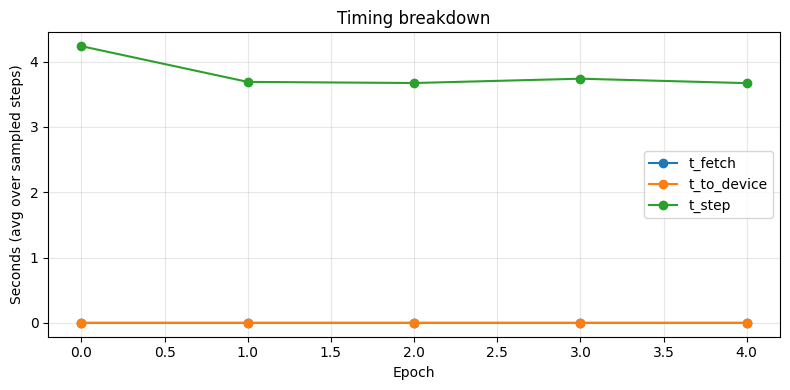

In [34]:
# If you had timing logs turned on you can access them here
latest_key, df = load_latest_training_log(bucket, log_dir)
print("Loaded:", f"s3://{bucket}/{latest_key}")
inspect_timing(df)

# Testing and Results
A function containing common testing functions post training. This is an example of what some local testing may be like, check easi-tools for specifics:

In [ ]:
#import torch
output_dir = f"{userid}/{project_name}/models/"
test_repo_prefix="AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v4_test-icechunk"

model = PrithviSegmentation(
        num_classes=11,
        freeze_backbone=True,)

best_model_uri = f"s3://{bucket}/{output_dir}model_best.pth"
test_model(test_repo_prefix, bucket, best_model_uri, test_snapshot_id=None, userid=userid, model=model)

# Be a good Dask user and close your cluster when you are done

In [21]:
client.close()
cluster.shutdown()